**Import dependecies**

In [2]:
'''
%conda install -c apple tensorflow-deps scipy #macos
%pip install tensorflow-macos tensorflow-metal #macos

%pip install --upgrade tensorflow 
%pip install pydot graphviz

%pip install pandas numpy pillow matplotlib scipy autopep8 pydot
'''

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
import os
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
import datetime

fruit = "apple"
model_current = "vgg16"
curr_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_prefix = f'./runs/{fruit}/{model_current}/{curr_datetime}/'
results_prefix = f'./results/{fruit}/{model_current}/{curr_datetime}/'
log_dir = f'logs/fit/{fruit}/{model_current}/{curr_datetime}'
os.makedirs(run_prefix, exist_ok=True)
os.makedirs(results_prefix, exist_ok=True)
run_prefix

**Create an imagedatagenerator object to label data**

In [4]:
input_size = 128
batch_size = 32
train_size = 8000
test_size = 2000
learning_rate = 0.001
epochs = 100
dropout = 0.2
dense_size = 1024

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
train_dir = f"./dataset_frutas_colab/{fruit}/train"
test_dir = f"./dataset_frutas_colab/{fruit}/test"
train_generator = train_datagen.flow_from_directory(train_dir,batch_size=batch_size,class_mode = 'binary', target_size=(input_size,input_size))
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=batch_size,class_mode = 'binary', target_size=(input_size,input_size))

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


VGG16 model

In [5]:
pre_trained_model = VGG16(
    input_shape = (input_size,input_size,3),
    include_top = False
)


Start transfer learning process

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [6]:
import tensorflow as tf
#Flatten
x = layers.Flatten()(pre_trained_model.output)
#Fully connected layer con 1,024 hidden units y ReLU
x = layers.Dense(dense_size, activation='relu')(x)
#Dropout rate
x = layers.Dropout(dropout)(x)
#Función de clasificación sigmoidal - Clasificación binaria
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer = Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.Accuracy(),
                         tf.keras.metrics.Precision(), 
                         tf.keras.metrics.Recall()])

In [7]:
tf.keras.utils.plot_model(
    model,
    to_file=f"{run_prefix}model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)
print("Saved Model Image")

Saved Model Image


In [8]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_generator,
    validation_data = test_generator,
    steps_per_epoch = train_size/batch_size,
    epochs = epochs,
    validation_steps = test_size/batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
500/500 [==============================] - 73s 135ms/step - loss: 0.2375 - accuracy: 0.0705 - precision: 0.9451 - recall: 0.9507 - val_loss: 0.0663 - val_accuracy: 0.0485 - val_precision: 0.9917 - val_recall: 0.9560
Epoch 2/100
500/500 [==============================] - 66s 132ms/step - loss: 0.0693 - accuracy: 0.1053 - precision: 0.9790 - recall: 0.9797 - val_loss: 0.0337 - val_accuracy: 0.1535 - val_precision: 0.9862 - val_recall: 0.9980
Epoch 3/100
500/500 [==============================] - 66s 132ms/step - loss: 0.0830 - accuracy: 0.1736 - precision: 0.9770 - recall: 0.9790 - val_loss: 0.0251 - val_accuracy: 0.1195 - val_precision: 0.9940 - val_recall: 0.9940
Epoch 4/100
500/500 [==============================] - 66s 132ms/step - loss: 0.0539 - accuracy: 0.1859 - precision: 0.9845 - recall: 0.9862 - val_loss: 0.0233 - val_accuracy: 0.1725 - val_precision: 0.9910 - val_recall: 0.9940
Epoch 5/100
500/500 [==============================] - 66s 132ms/step - loss: 0.0520 - a

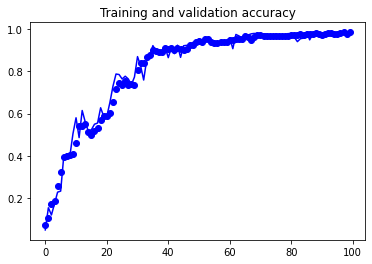

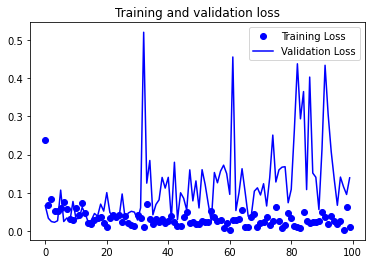

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
recall = history.history['recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.savefig(f"{run_prefix}acc.svg")
plt.figure()


plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(f"{run_prefix}loss.svg")

plt.show()

In [10]:
#model.save(f"{run_prefix}{model_current}.h5")

In [11]:
import csv

header = ["train_acc", "val_acc", "train_loss", "val_loss", "precision", "recall"]

with open(f'{results_prefix}metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
    for idx in range(len(acc)):
        line = [acc[idx],val_acc[idx],loss[idx],val_loss[idx], precision[idx], recall[idx]]        
        writer.writerow(line)
